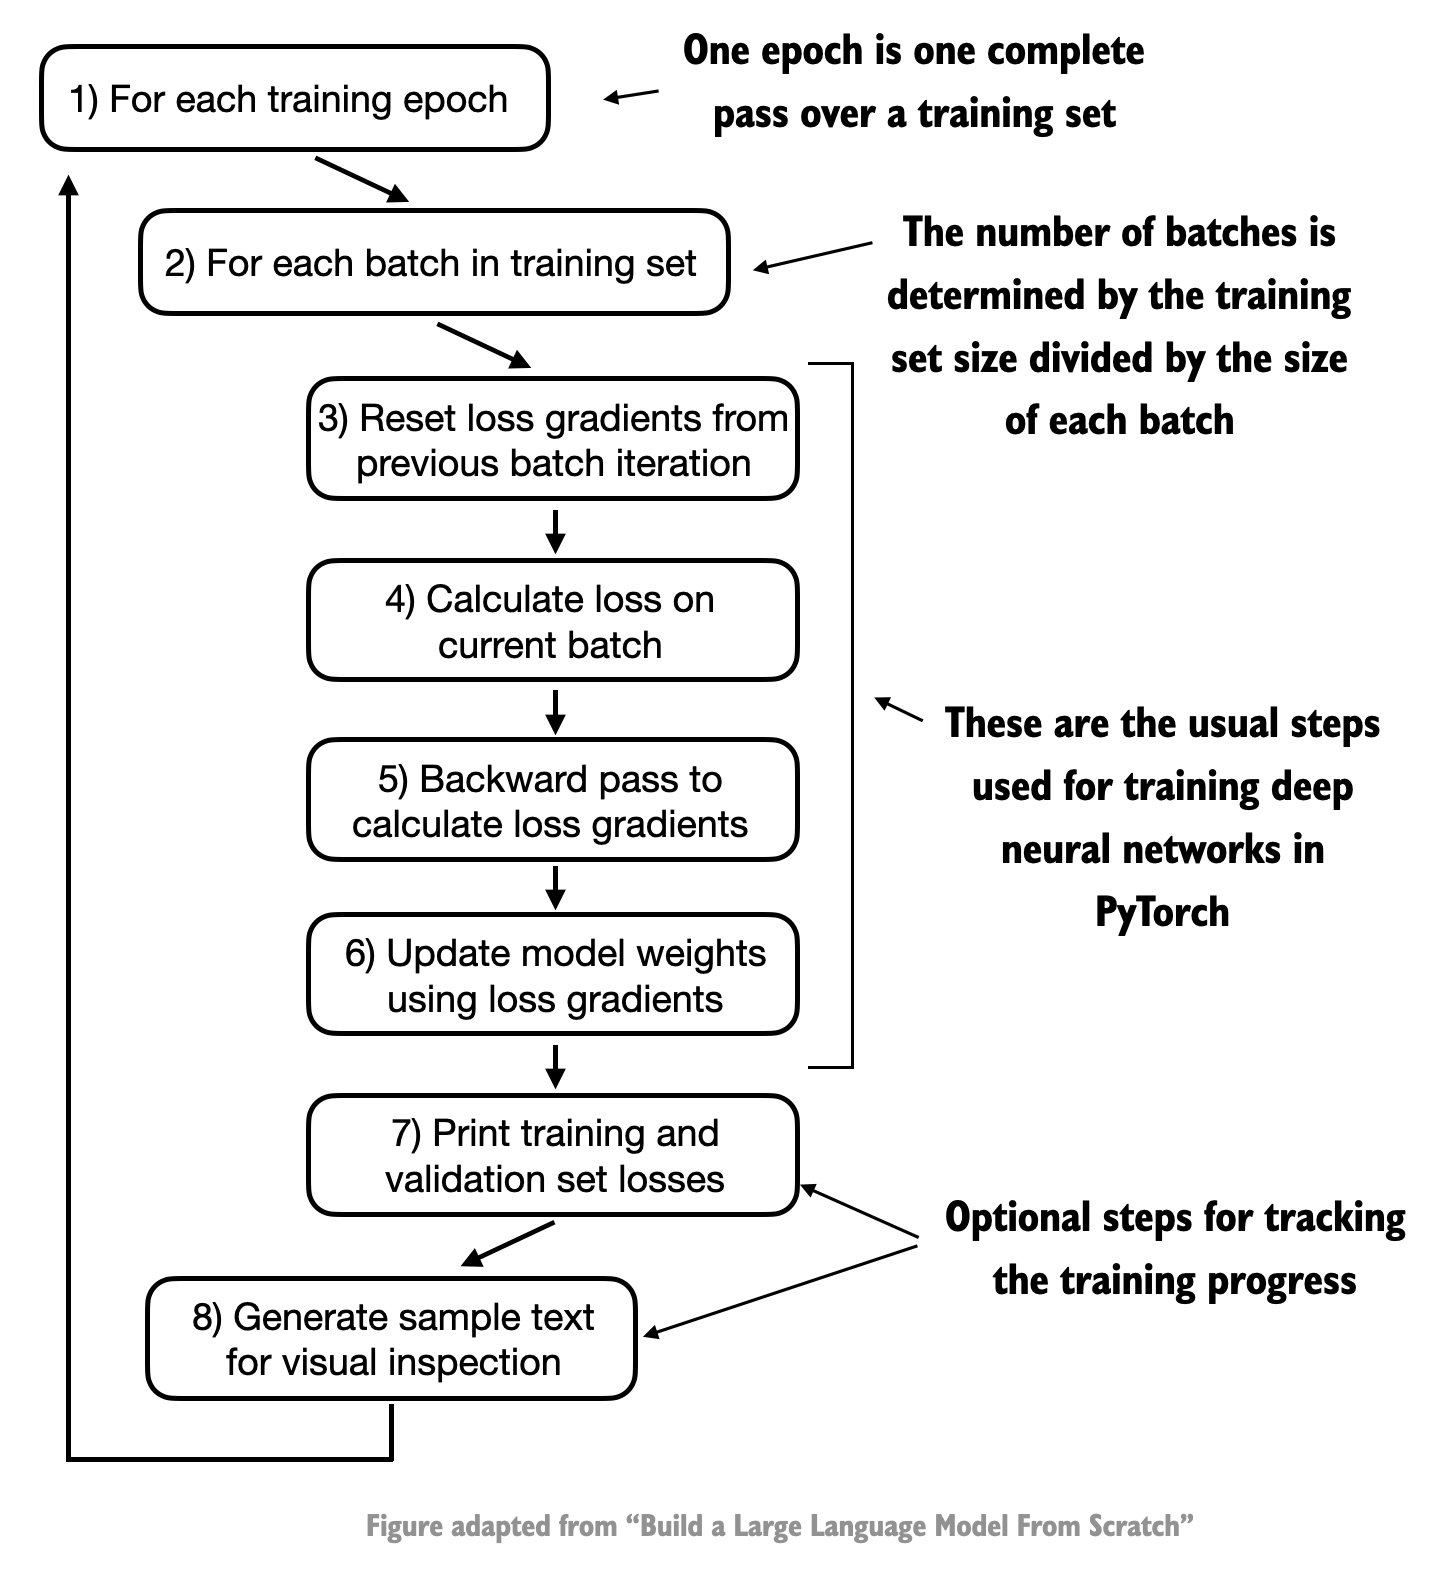

## 0. Imports

In [1]:
# Update sys path for imports to work
import sys
# print(f"Before: {"\n".join(sys.path)}")  ## Optional print to check
sys.path.append("../../../LLMFromScratch")
# print(f"After: {"\n".join(sys.path)}")  ## Optional print to check

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch


from M0_data.helpers import GPT2Tokenizer
from M1_simple_gpt_model.generate import generate_text
from M1_simple_gpt_model.trial_gpt_model import TrialGPTModel
from M2_pretraining.evaluate import calc_loss_batch, evaluate_model

## 1. Initialisations

### 1.1. Tokenizers

In [3]:
tokenizer = GPT2Tokenizer()

### 1.2. Model

In [4]:
GPT_CONFIG_124M = {
    "context_length": 256, # Context Length supported by the model; Using reduced size to reduce compute resources; Actual value: 1024
    "drop_rate" : 0.1,  # Tring with smaller prob number, Can be kept zero.
    "emb_dim": 768,  # Dimension of Embedding to be created
    "n_heads": 12,  # Number of heads in Multi-Head Attention
    "n_layers": 12,  # Number of times Transformer block is repeated
    "qvbias": False,  # Skipping bias terms to make the transformers training faster
    "vocab_size": 50257,  # Size of gpt2 tokenizer used
}

In [5]:
torch.manual_seed(123)  # For consistent reproducibility
model = TrialGPTModel(GPT_CONFIG_124M, print_interims=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TrialGPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (norm_1): LayerNorm()
      (multi_head_attention): MultiHeadAttention(
        (linear_query): Linear(in_features=768, out_features=768, bias=False)
        (linear_key): Linear(in_features=768, out_features=768, bias=False)
        (linear_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj_linear): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm_2): LayerNorm()
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): TransformerBlock(
      (norm_1)

### 1.3 Optimizer

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

### 1.4 Datasets

In [8]:
train_data_loader = torch.load("intermediates/train_loader.pt", weights_only=False)
validation_data_loader = torch.load("intermediates/validation_loader.pt", weights_only=False)

# Tests
for in_data, out_data in train_data_loader:
    print(in_data.shape, out_data.shape)
print("------------------")
for in_data, out_data in validation_data_loader:
    print(in_data.shape, out_data.shape)

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
------------------
torch.Size([2, 256]) torch.Size([2, 256])


## 2. Model Training

In [11]:
def generate_print_sample(model, test_string, tokenizer, max_output_tokens = 10):

    # 1. Tokenize
    tokenized_in_string = tokenizer.tokenize_batch([test_string])
    context_length = model.pos_emb.weight.shape[0]

    # 2. Model to Eval mode and generate text
    model.eval()  # Set Model to Evaluation
    with torch.no_grad():
        output_tokens = generate_text(model, tokenized_in_string, max_output_tokens, context_length, print_interims=False)
    model.train()  # Reset Model to train mode

    # 3. Detokenize and Print
    output = tokenizer.detokenize_batch(output_tokens)
    print(output[0])

In [12]:
# Test
generate_print_sample(model, "The story revolves around ", tokenizer)

The story revolves around     Windsor Shooting1983 overboard vide Gael EditingRAM politically


In [13]:
def train_model(model, device,  #  Model Related inputs
                num_epochs, optimizer,  #  Parameters needed for training
                train_data_loader, validation_data_loader, tokenizer,  # Train & Validation data related
                test_string, eval_freq, eval_batch_size):  # Evlauation required inputs
    # ======== These variables are Optional - To track losses ========
    global_step = -1  # Starting from -1 so that first step is printed
    tokens_seen = 0

    train_losses, validation_losses, tokens_seen_tracker = [], [], []  # Collected to print plot later - To be returned
    # ================================================================

    for epoch in range(num_epochs):
        model.train()  # Set model to train mode

        for input_batch, target_batch in train_data_loader:
            optimizer.zero_grad()  # 1. Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, device, model)  # 2. Calculate loss of the batch
            loss.backward()  # 3. Calculate loss gradients
            optimizer.step() # 4. Update model weights using loss gradients

            # ======== Below section is optional to track losses ========
            global_step += 1
            tokens_seen += input_batch.numel()

            if global_step % eval_freq == 0:
                train_loss, validation_loss = evaluate_model(model, train_data_loader, validation_data_loader, device, eval_batch_size)
                train_losses.append(train_loss)
                validation_losses.append(validation_loss)
                tokens_seen_tracker.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {validation_loss:.3f}")

            # ========================================================

        # Print sample after each epoch to observe improvement in train quality
        print(f"Epoch: {epoch+1}")
        generate_print_sample(model, test_string, tokenizer)

    return train_losses, validation_losses, tokens_seen_tracker

In [14]:
num_epochs = 25

In [15]:
# Train
train_losses, validation_losses, tokens_seen_tracker = train_model(model, device, 
                                                           num_epochs, optimizer,
                                                           train_data_loader, validation_data_loader, tokenizer, 
                                                           "The story revolves around ", 5, 5)

Ep 1 (Step 000000): Train loss 9.601, Val loss 9.984
Ep 1 (Step 000005): Train loss 7.414, Val loss 7.802
Epoch: 1
The story revolves around  to the Chola and the Chola and th
Ep 2 (Step 000010): Train loss 5.287, Val loss 6.306
Ep 2 (Step 000015): Train loss 4.205, Val loss 5.771
Epoch: 2
The story revolves around  the Chola and his the Chola and his
Ep 3 (Step 000020): Train loss 3.361, Val loss 5.365
Ep 3 (Step 000025): Train loss 2.784, Val loss 5.221
Epoch: 3
The story revolves around  the Chola country. They Chola and his
Ep 4 (Step 000030): Train loss 2.378, Val loss 5.169
Ep 4 (Step 000035): Train loss 1.792, Val loss 5.134
Epoch: 4
The story revolves around  her. Vandiyathevan, the Chola
Ep 5 (Step 000040): Train loss 1.428, Val loss 5.140
Epoch: 5
The story revolves around  her. Vandiyin Selvan, Vandiy
Ep 6 (Step 000045): Train loss 1.215, Val loss 5.106
Ep 6 (Step 000050): Train loss 1.098, Val loss 5.111
Epoch: 6
The story revolves around  her. The next day, Vandiyatheva
Ep

## 3. Save model

In [16]:
torch.save(model.state_dict(),"intermediates/trained_model.pt")

## 4. Plot Losses

In [17]:
def plot_losses(epochs_seen, train_losses, validation_losses, tokens_seen, path_to_save=None):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, validation_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    if path_to_save:
        plt.savefig(path_to_save)
    plt.show()

In [18]:
epochs_seen = torch.linspace(0, num_epochs, len(train_losses))

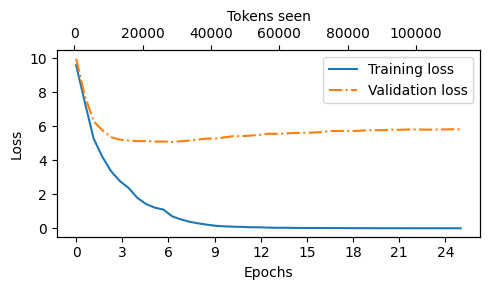

In [19]:
plot_losses(epochs_seen, train_losses, validation_losses, tokens_seen_tracker,"intermediates/losses_plot.pdf")

## 5. Reload Trained model and Infer

### 5.1. Load Trained Model

In [20]:
trained_model = TrialGPTModel(GPT_CONFIG_124M, print_interims=False)
trained_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.load_state_dict(torch.load("intermediates/trained_model.pt", map_location=device,weights_only=False))
model.eval()  # Set to evaluation mode

TrialGPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (norm_1): LayerNorm()
      (multi_head_attention): MultiHeadAttention(
        (linear_query): Linear(in_features=768, out_features=768, bias=False)
        (linear_key): Linear(in_features=768, out_features=768, bias=False)
        (linear_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj_linear): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm_2): LayerNorm()
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): TransformerBlock(
      (norm_1)

### 5.2 Test Trained Model

In [21]:
test_tokenizer = GPT2Tokenizer()

In [22]:
generate_print_sample(trained_model, "The story revolves around ", test_tokenizer)

The story revolves around  all his will to become the Chola emperor bu


In [28]:
generate_print_sample(trained_model, "Vandiyathevan is a ", test_tokenizer)

Vandiyathevan is a , a charming, brave and courageous young man wh
